# Example: Rabi oscillations with a Gaussian beam and thermal atoms

We simulate the decay of Rabi oscillation in the presence of thermal motion. Note that at the moment this only includes the motion within the $x$-$y$ plane, as well as in the $z$ direction. The parameters that we use here are roughly the ones that are achieved with the atom interferometer [GAIN](https://www.physics.hu-berlin.de/en/qom/research/ai).

The simulation will require the following objects and parameters
* `IntensityProfile`: contains information about the Gaussian beams
* `Wavevectors`: the wavevectors are important for the incorporation of the Doppler shift along $z$
* `AtomicEnsemble`: an ensemble of atoms which different trajectors or phase space vectors
* `Detector`: determines which atoms contribute to the signal
* `t`: time of flight before the lasers are turned on

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

### Detector

Setting up da detector with a fixed detection radius and time.

In [2]:
t_det = 778e-3 # time of the detection in s
r_det = 5e-3 # size of detected region in x-y plane

det = ais.SphericalDetector(t_det, r_det=r_det) # set detection region

### Atomic cloud and state vectors

Here we use a Monte-Carlo method by randomly drawing positions and velocities from a distribution. We initialize all atoms in the excited state, represented by a state vector `[0, 1]`.

In [3]:
pos_params = {
     'mean_x': 0.0,
     'std_x' : 3.0e-3, # cloud radius in m
     'mean_y': 0.0,
     'std_y' : 3.0e-3, # cloud radius in m
     'mean_z': 0.0,
     'std_z' : 0.0,        # ignore z dimension, its not relevant here
}
vel_params = {
     'mean_vx': 0.0,
     'std_vx' : ais.convert.vel_from_temp(3.0e-6), # cloud velocity spread in m/s at tempearture of 3 uK
     'mean_vy': 0.0,
     'std_vy' : ais.convert.vel_from_temp(3.0e-6), # cloud velocity spread in m/s at tempearture of 3 uK
     'mean_vz': 0.0,
     'std_vz' : ais.convert.vel_from_temp(160e-9), # after velocity selection, velocity in z direction is 160 nK
}

atoms = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params,
    vel_params, int(1e4),
    state_kets=[0, 1],
    seed=1)

We visualize the spread of the atomic ensemble and its convolution with the detector.

Text(0, 0.5, 'y / mm')

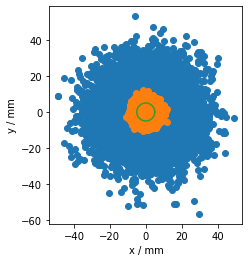

In [4]:
x0 = atoms.initial_position[:, 0]
y0 = atoms.initial_position[:, 1]

x_det = atoms.calc_position(t_det)[:, 0]
y_det = atoms.calc_position(t_det)[:, 1]

fig, ax = plt.subplots()
ax.scatter(1e3*x_det, 1e3*y_det, label='cloud at detection')
ax.scatter(1e3*x0, 1e3*y0, label='initial cloud')
angle = np.linspace(0, 2*np.pi, 100)
ax.plot(1e3*r_det*np.cos(angle), 1e3*r_det*np.sin(angle), c='C2', label='detection region')

ax.set_aspect('equal', 'box')

ax.set_xlabel('x / mm')
ax.set_ylabel('y / mm')

In [5]:
n_init = len(atoms)
atoms = det.detected_atoms(atoms)

print("{} of the initial {} atoms are detected. That's {}%".format(len(atoms), n_init, len(atoms)/n_init*100))

452 of the initial 10000 atoms are detected. That's 4.52%


### Intensity profile

We set up an intensity profile of the interferometry laser, defined by the center Rabi frequency

In [6]:
center_rabi_freq = 2*np.pi*12.5e3 # center Rabi frequency in Hz
r_beam = 29.5e-3/2 # 1/e^2 beam radius in m
intensity_profile = ais.IntensityProfile(r_beam, center_rabi_freq)

### Wave vectors

We set up the two wavevectors used to drive the Raman transitions:

In [7]:
wave_vectors = ais.Wavevectors( k1 = 2*np.pi/780e-9, k2 = -2*np.pi/780e-9)

### Simulation

First, we freely propagate the atomic ensemble to the time when we start the Rabi oscillations by applying a light pulse. We save the resulting `AtomicEnsemble` in two objects since we want to perform two different simulations with this ensemble.

In [8]:
atoms1 = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params,
    vel_params, int(1e4),
    state_kets=[0, 1])
atoms2 = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params,
    vel_params, int(1e4),
    state_kets=[0, 1])

atoms1 = det.detected_atoms(atoms1)
atoms2 = det.detected_atoms(atoms2)

free_prop = ais.FreePropagator(129e-3)

atoms1 = free_prop.propagate(atoms1)
atoms2 = free_prop.propagate(atoms2)

The current position of the atoms is stored in `atoms.positions` and the `time` attribute has changed accordingly:

We now simulate the effect of the pulse length in two different ways. First, we neglect the motion of the atoms in the $z$ direction, then we incorporate the Doppler effect caused by the finite temperature in $z$. We first set up two different propagators for this:

In [9]:
prop1 = ais.TwoLevelTransitionPropagator(time_delta=1e-6, intensity_profile=intensity_profile)
prop2 = ais.TwoLevelTransitionPropagator(time_delta=1e-6, intensity_profile=intensity_profile, wave_vectors=wave_vectors)

In [10]:
state_occupation1 = []
state_occupation2 = []
taus = np.arange(200) * 1e-6
for tau in taus:
    # acting on the states in `atom` at each run
    atoms1 = prop1.propagate(atoms1)
    atoms2 = prop2.propagate(atoms2)
    # mean occupation of the excited state
    state_occupation1.append(np.mean(atoms1.state_occupation(state=1)))
    state_occupation2.append(np.mean(atoms2.state_occupation(state=1)))

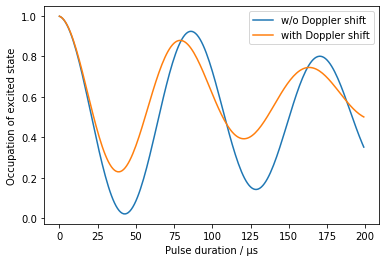

In [11]:
fig, ax = plt.subplots()
ax.plot(1e6*taus, state_occupation1, label='w/o Doppler shift')
ax.plot(1e6*taus, state_occupation2, label='with Doppler shift')
ax.set_xlabel('Pulse duration / μs')
ax.set_ylabel('Occupation of excited state');
ax.legend()